# Impression Generation with FLAN-T5
This notebook implements and evaluates a FLAN-T5 model for generating Impression fields.

## Library Imports

Importing required libraries for the project:

### Standard Libraries:
- `numpy`: For numerical computations and array operations
- `matplotlib.pyplot`: For creating visualizations
- `pandas`: For data manipulation and analysis
- `torch`: For deep learning operations
- `time`: For monitoring execution time
- `AzureOpenAI`: For accessing GPT-4 evaluation services

### Hugging Face Libraries:
- `datasets`: For efficient dataset handling and processing
- `transformers`: For working with the FLAN-T5 model and tokenizer
- `Trainer`, `TrainingArguments`: For model fine-tuning

### Custom Utilities:
- `utils_file`: Custom functions for:
  - Data preprocessing (`build_finetuning_prompt`, `preprocess_finetuning`)
  - Model evaluation (`run_generation_on_dataframe`, `generate_predictions_from_test_dataframe`)
  - Performance assessment (`run_equivalence_judgment_flan`, `compute_bertscore`)

In [ ]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import time
from openai import AzureOpenAI

# Hugging Face
from datasets import Dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments

import sys
sys.path.append('..')

# Local utils
from utils_file import (
    build_finetuning_prompt,
    preprocess_finetuning,
    run_generation_on_dataframe,
    generate_predictions_from_test_dataframe,
    run_equivalence_judgment_flan,
    compute_bertscore
)


## Load Dataset

Loading the preprocessed cleaned dataset.

In [ ]:
df_cleaned = pd.read_csv("indiana_reports_cleaned.csv")


## Initialize FLAN-T5 Model

Loading the pre-trained FLAN-T5 base model components:

1. **Model Name**: Using `google/flan-t5-base`, a powerful base model for text generation tasks
2. **Tokenizer**: Loading the model's tokenizer for text preprocessing
3. **Model**: Loading the model architecture with automatic device placement:
   - Uses CUDA GPU if available
   - Falls back to CPU if no GPU is present

This base model will serve as our starting point for impression generation.

In [ ]:

# Load model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")


## Generate Baseline Predictions

Running initial impression generation with the base FLAN-T5 model:

1. Process a sample of 300 reports from the cleaned dataset
2. Generate impressions using the base model without fine-tuning
3. Save the results to 'generated_impressions_300_flan.csv' for evaluation

This establishes our baseline performance before fine-tuning.

In [ ]:

results_baseline_df = run_generation_on_dataframe(df_cleaned, tokenizer, model, sample_size=300)
results_baseline_df.to_csv("generated_impressions_300_flan.csv", index=False)


## Configure Azure OpenAI

Setting up the Azure OpenAI client for GPT-4 access. This will be used for evaluating clinical equivalence.

In [ ]:
# Set up Azure OpenAI client
client = AzureOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://yaniv-mb5gqe3y-eastus2.openai.azure.com/",
    api_key="8XhaidlpT0fIOsTT6ynrB5BmtYMP0yoTE2giiovjNDMNYNxBsNpYJQQJ99BEACHYHv6XJ3w3AAAAACOGnVgO"
)

## Evaluate Baseline Predictions

Using GPT-4 to assess the clinical equivalence between generated and ground truth impressions.

In [ ]:

results_baseline_df , correct, total, acc = run_equivalence_judgment_flan(
    results_baseline_df,
    client,
    model_name="gpt-4o",
    save_path="results_with_azure_gpt_judgment_baseline.csv"
)


Clinical Equivalence Rate: 4/300 = 1.3%
✅ Saved equivalence results to 'results_with_azure_gpt_judgment_baseline.csv'


## Calculate Baseline BERTScore

Computing BERTScore metrics to evaluate semantic similarity between baseline predictions and reference impressions.

In [ ]:

# Compute BERTScore for baseline model predictions (אם קיים)
bert_results_baseline = compute_bertscore(
    results_baseline_df,
    candidate_col="generated_impression",
    reference_col="true_impression",
    name_prefix="baseline"
)

## Fine-tune FLAN-T5 Model

1. Prepare training data:
   - Create input-target pairs
   - Convert to HuggingFace Dataset format
   - Split into train/validation/test sets (80/10/10)
2. Configure training parameters
3. Initialize trainer and start fine-tuning

In [ ]:


# Preparing the texts for training
df_cleaned["input_text"] = df_cleaned.apply(build_finetuning_prompt, axis=1)
df_cleaned["target_text"] = df_cleaned["impression"]

# Conversion to Hugging Face Dataset
dataset = Dataset.from_pandas(df_cleaned[["input_text", "target_text"]])

# Divided into 80% training, 20% testing
split = dataset.train_test_split(test_size=0.2, seed=42)
train_eval_dataset = split["train"]
test_dataset = split["test"]

# Saving the test to disk for future use
test_dataset.save_to_disk("saved_test_dataset")
print("✅ Test set saved to 'saved_test_dataset'")

# Loading Tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# Tokenization on training+intermediate evaluation
tokenized_dataset = train_eval_dataset.map(lambda x: preprocess_finetuning(x, tokenizer))

# Splitting into 90% training, 10% validation
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]



# Setting the training parameters
training_args = TrainingArguments(
    output_dir="./finetuned_impression",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    eval_steps=100,
    save_steps=500,
    save_total_limit=2,
    remove_unused_columns=True,
    report_to="none",
)

# Loading the model
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

# Setting the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Starting training
trainer.train()





## Save Fine-tuned Model

Saving the fine-tuned model and tokenizer for later use and evaluation.

In [ ]:
# Save the model and tokenizer after training
trainer.save_model("./final_finetuned_model")
tokenizer.save_pretrained("./final_finetuned_model")
print("✅ Model and tokenizer saved successfully.")


✅ Model and tokenizer saved successfully.


## Load Test Data and Model

Loading the saved test dataset and fine-tuned model components for evaluation.

In [ ]:


# Load the saved test set
test_dataset = load_from_disk("saved_test_dataset")
print(f"✅ Loaded test dataset with {len(test_dataset)} samples")

# Load the fine-tuned model and tokenizer
model_path = "./final_finetuned_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
print("✅ Model and tokenizer loaded successfully.")


✅ Loaded test dataset with 667 samples
✅ Model and tokenizer loaded successfully.


## Generate Fine-tuned Predictions

Generating impressions on the test set using the fine-tuned model and saving results.

In [ ]:


# Convert test dataset to DataFrame
test_df = test_dataset.to_pandas()

# Generate predictions
results_finetuned_df = generate_predictions_from_test_dataframe(test_df, tokenizer, model)

# Save to CSV
results_finetuned_df.to_csv("finetuned_model_test_results.csv", index=False)
print("✅ Saved test set predictions to 'finetuned_model_test_results.csv'")


✅ Saved test set predictions to 'finetuned_model_test_results.csv'


## Evaluate Fine-tuned Predictions

Assessing clinical equivalence of fine-tuned model predictions using GPT-4.

In [ ]:

# Run equivalence judgment (with the original FLAN-style prompt)
results_finetuned_df, correct_ft, total_ft, acc_ft = run_equivalence_judgment_flan(
    results_finetuned_df,
    client,
    model_name="gpt-4o",
    save_path="results_with_azure_gpt_judgment_finetuned.csv"
)

print(f"✅ Saved equivalence results to 'results_with_azure_gpt_judgment.csv'")
print(f"✅ Clinical Equivalence Rate: {correct}/{total} = {acc:.1f}%")


Clinical Equivalence Rate: 318/667 = 47.7%
✅ Saved equivalence results to 'results_with_azure_gpt_judgment.csv'
✅ Saved equivalence results to 'results_with_azure_gpt_judgment.csv'
✅ Clinical Equivalence Rate: 318/667 = 47.7%


## Calculate Fine-tuned BERTScore

Computing BERTScore metrics for the fine-tuned model's predictions.

In [ ]:



# Compute BERTScore for fine-tuned model predictions
bert_results_finetuned = compute_bertscore(
    results_finetuned_df,
    candidate_col="generated_impression",
    reference_col="true_impression",
    name_prefix="finetuned"
)



## Prepare Comparison Metrics

Collecting evaluation scores from both baseline and fine-tuned models for comparison.

In [ ]:

llmjudge_baseline = acc
llmjudge_finetuned = acc_ft

llmjudge_scores = [llmjudge_baseline, llmjudge_finetuned]

## Visualize Performance Comparison

Creating a comparative visualization showing:
- LLM Judge scores (clinical equivalence %)
- BERTScore metrics (F1 scores)
for both baseline and fine-tuned models.

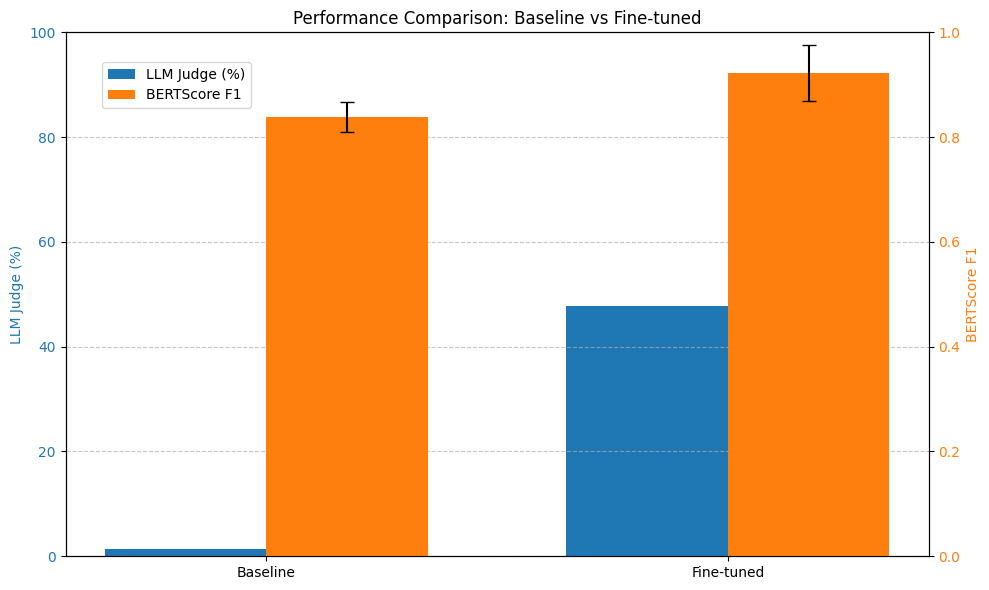

In [ ]:

# Labels
labels = ['Baseline', 'Fine-tuned']

# LLM Judge scores (percentages)
llmjudge_scores = [llmjudge_baseline, llmjudge_finetuned]

# BERTScore means and stds
bertscore_means = [
    bert_results_baseline["baseline_mean"],
    bert_results_finetuned["finetuned_mean"]
]
bertscore_stds = [
    bert_results_baseline["baseline_std"],
    bert_results_finetuned["finetuned_std"]
]

x = np.arange(len(labels))
width = 0.35

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for LLM Judge
bar1 = ax1.bar(x - width/2, llmjudge_scores, width, label='LLM Judge (%)', color='tab:blue')
ax1.set_ylabel('LLM Judge (%)', color='tab:blue')
ax1.set_ylim(0, 100)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Second y-axis for BERTScore
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, bertscore_means, width, yerr=bertscore_stds, label='BERTScore F1', color='tab:orange', capsize=5)
ax2.set_ylabel('BERTScore F1', color='tab:orange')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add title and legend
plt.title('Performance Comparison: Baseline vs Fine-tuned')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show grid
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
